# BAT.jl Tutorial - Poisson Counting Experiment

In [1]:
using BAT
using Distributions 
using IntervalSets
using ValueShapes
using Plots
using ArraysOfArrays
using StatsBase 
pyplot();

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1242
ERROR: LoadError: LoadError: PyCall not properly installed. Please run Pkg.build("PyCall")
Stacktrace:
 [1] error(::String) at ./error.jl:33
 [2] top-level scope at /home/cornelius/.julia/packages/PyCall/ttONZ/src/startup.jl:44
 [3] include at ./boot.jl:328 [inlined]
 [4] include_relative(::Module, ::String) at ./loading.jl:1094
 [5] include at ./Base.jl:31 [inlined]
 [6] include(::String) at /home/cornelius/.julia/packages/PyCall/ttONZ/src/PyCall.jl:1
 [7] top-level scope at /home/cornelius/.julia/packages/PyCall/ttONZ/src/PyCall.jl:41
 [8] include at ./boot.jl:328 [inlined]
 [9] include_relative(::Module, ::String) at ./loading.jl:1094
 [10] include(::Module, ::String) at ./Base.jl:31
 [11] top-level scope at none:2
 [12] eval at ./boot.jl:330 [inlined]
 [13] eval(::Expr) at ./client.jl:432
 [14] top-level scope at ./none:3
in expression starting at /home/cornelius/.julia/packages/PyCall/ttONZ

ErrorException: Failed to precompile PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee] to /home/cornelius/.julia/compiled/v1.2/PyPlot/oatAj.ji.

## Situation
We want to determine the properties of a radioactive singal source in the presence of background from natural sources of radioactivity.
We assume to have one signal source $S$ and only one source of background $B$.

## 1. Background only measurement
We start by using our detector without the signal source installed.
This measurement yields a number of $N_B=10$ counts.
Using this measurement we want to gain information about the event rate of the natural radioactive background.

### Task: 
Perform a Bayesian analysis to estimate the event rate of the natural background $\lambda_b$ using a Poisson model. 

Start by defining the model and its likelihood using the `logpdf()` and `Poisson()` functions from the [Distrtibutions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/) package:

In [2]:
# Number of observed background events
kb = 10

likelihood_B = let k = kb
    params -> begin
        return logpdf(Poisson(params.λb), k) # poisson log-likelihood
    end
end

#3 (generic function with 1 method)

Define the Prior with help of the `NamedPrior()` function. Use a flat prior between 0 and 30.  
Afterwards, use the likelihood and the prior to define the `PosteriorDensity()`:

In [3]:
prior_B = NamedPrior(
    λb = 0..30
    #!EX λb = #!...!#
)

posterior_B = PosteriorDensity(likelihood_B, prior_B);
#!EX posterior_B = PosteriorDensity(#!...!#); 

Define the settings for the sampling. Choose `MetropolisHstings()` as your algorithm and set the number of chains and samples:

In [4]:
algorithm = MetropolisHastings()
nchains = 8
nsamples = 10^5;

Start the sampling by using `rand()` on the `MCMCSpec()` object with the settings defined above:

In [5]:
samples_B, sampleids_B, stats_B, chains_B = rand(MCMCSpec(algorithm, posterior_B), nsamples, nchains);

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 2 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 3 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 4 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:

Take a look at the resulting disribution for the background rate using `plot()`:

200


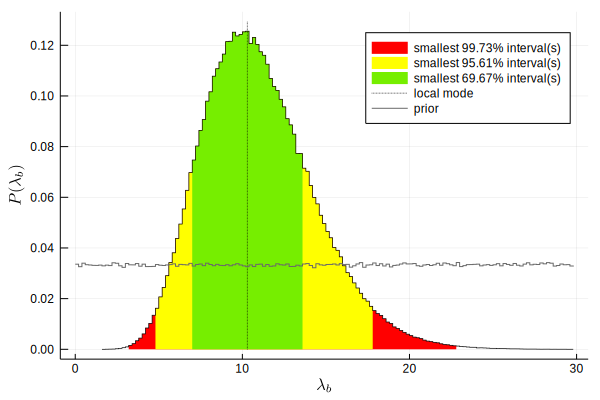

In [6]:
plot(posterior_B, samples_B, :λb)
plot!(prior_B, :λb, xlabel = "\$\\lambda_b\$", ylabel = "\$P(\\lambda_b)\$")

Print some numeric results of the sampling:

In [7]:
println("Mode: $(stats_B.mode)")
println("Mean: $(stats_B.param_stats.mean)")
#println("Covariance: $(stats_B.param_stats.cov)")
println("Standard Deviation: $([sqrt((stats_B.param_stats.cov)[i,i]) for i in 1:(Int(sqrt(length(stats_B.param_stats.cov))))])")

Mode: [9.999995840797432]
Mean: [10.994862552002603]
Standard Deviation: [3.3211689377291655]


## 2. Second background only measurement
A second measurement of the natural background yields a number of $N_B=8$ counts.  
Therefore, we want to update our estimation of the background rate using this new knowledge together with the pervious results.
### Task:
Perform an analysis of the new measurement similar to the first one. Use the posterior distribution of the previous background measurement as a prior for this analysis.  
This can be done by using a `StatsBase` histogram of the samples: `fit(Histogram,flatview(samples)[i,:], weights, nbins)`.  
The weights of the samples need to be used with the `FrequencyWeights()` function.

In [8]:
posterior_hist_B1 = fit(Histogram, flatview(samples_B.params)[1, :], FrequencyWeights(samples_B.weight), nbins = 400, closed = :left);

The histogram can be used as a prior by converting it into a univariate distribution using `BAT.HistogramAsUvDistribution()`.  
Apart from that, you can proceed similarly to the first task.

Define the likelihood:

In [9]:
kb2 = 8

likelihood_B2 = let k = kb2
    params -> begin
        return logpdf(Poisson(params.λb), k)
    end
end
#!EX likelihood_B2 = let k = kb2 = #!...!#


┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


Define the prior (use the posterior of the previous task).  
Define the posterior.

In [ ]:
prior_B2 = NamedPrior(
    λb = BAT.HistogramAsUvDistribution(posterior_hist_B1)
)
#!EX prior_B2 = NamedPrior( #!...!# )

posterior_B2 = PosteriorDensity(likelihood_B2, prior_B2);
#!EX posterior_B2 #!...!#

Generate samples:

In [10]:
samples_B2, sampleids_B2, stats_B2, chains_B2 = rand(MCMCSpec(algorithm, posterior_B2), nsamples, nchains);
#!EX samples_B2, sampleids_B2, stats_B2, chains_B2 = #!...!#

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC tuning of 8 chains successful after 1 cycle(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:88


In [11]:
println("Mode: $(stats_B2.mode)")
println("Mean: $(stats_B2.param_stats.mean)")
#println("Covariance: $(stats_B2.param_stats.cov)")
println("Standard Deviation: $([sqrt((stats_B2.param_stats.cov)[i,i]) for i in 1:(Int(sqrt(length(stats_B2.param_stats.cov))))])")

Mode: [9.000004987708698]
Mean: [9.494935143558436]
Standard Deviation: [2.183811535192737]


Use the `plot!(prior)` function to visualize both the posterior of the first analysis and the updated posterior:

200


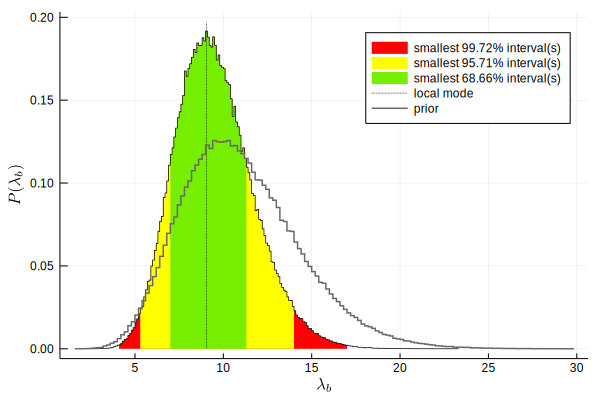

In [12]:
plot(posterior_B2, samples_B2, :λb)
plot!(prior_B2, :λb, linewidth=1.5, xlabel = "\$\\lambda_b\$", ylabel = "\$P(\\lambda_b)\$")
#!EX #!...!#

## 3. Signal + Background
Including the radioactive source to the experimental setup, we repeat the measurement and obtain $N_{S+B}=12$ counts.
With this measurement and our prior knowledge about the background we are able to estimate the rate of the signal $\lambda_s$.
### Task
Perform a third analysis using a poisson model with the combined singal + background rate.
Use the known information about the background from the previous tasks as a prior and choose a suitable prior for the signal.

Define the likelihood for the signal + background model:

In [13]:
# Number of observed events
kSB = 12

likelihood_SB = let k = kSB
    params -> begin
        return logpdf(Poisson(params.λb + params.λs), k)  # poisson log-likelihood for b+s
    end
end
#!EX likelihood_SB = let k = kSB #!...!#

#11 (generic function with 1 method)

Define the prior for both the signal and backgound parameters.  
Remember to use the knowledge from the previous tasks for the background. (hint: `BAT.HistogramAsUvDistribution()`)  
Also define the posterior.

In [15]:
hist_B2 = fit(Histogram, flatview(samples_B2.params)[1, :], FrequencyWeights(samples_B2.weight), nbins = 400, closed = :left)
B2 = BAT.HistogramAsUvDistribution(hist_B2);

prior_SB = NamedPrior(
    λb = B2,
    λs = 0..30
)

posterior_SB = PosteriorDensity(likelihood_SB, prior_SB);

Generate samples for the signal + background model:

In [16]:
samples_SB, sampleids_SB, stats_SB, chains_SB = rand(MCMCSpec(algorithm, posterior_SB), nsamples, nchains);
#!EX samples_SB, sampleids_SB, stats_SB, chains_SB = #!...!#

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC tuning of 8 chains successful after 1 cycle(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:88


To visualize the results for both prameters, use `plot(samples)`.   
(Hint: use the keyword `param_labels=["\$\\lambda_b\$","\$\\lambda_s\$"]` for correct axis labels)

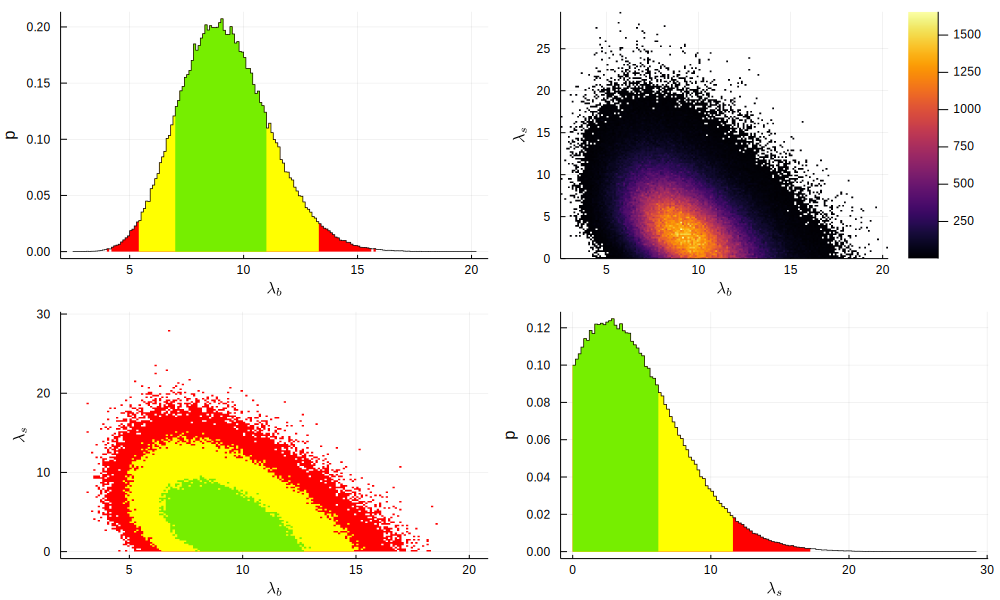

In [17]:
plot(samples_SB, param_labels=["\$\\lambda_b\$","\$\\lambda_s\$"])
#!EX #!...!#

In [18]:
println("Mode: $(stats_SB.mode)")
println("Mean: $(stats_SB.param_stats.mean)")
#println("Covariance: $(stats_SB.param_stats.cov)")
println("Standard Deviation: $([sqrt((stats_SB.param_stats.cov)[i,i]) for i in 1:(Int(sqrt(length(stats_SB.param_stats.cov))))])")

Mode: [9.083835302847294, 2.9161088248225786]
Mean: [9.19645382202858, 4.85952155335984]
Standard Deviation: [1.9802746548666985, 3.39413332904554]


## 4. Error propagation

Finally, we want to caluclate the cross section of the signal process.
The rate of measured events in the detector of a couting experiment can be written as 

$\frac{\mathrm d N}{\mathrm d t} = ε \cdot σ \cdot L$ ,

with the Luminosity $L$ and the efficiency of the detector $ε$.   
Therefore, the signal cross section can be derived as:
### $σ_S = \frac{λ_s}{ε \cdot L}$  .
For this experiment (and neglecting units) we assume a luminosity $L = 1.1$.

As a final result we want to obtain either a measurement or an upper limit on the signal cross section.

### Task 4a) Known efficiency with gaussian uncertainty
The detector efficiency has been measured to be $ε = 0.1 \pm 0.02$, assuming the uncertainties to follow a normal distribution.

Calculate the signal cross section $σ_S$ using the equation above.

Use the [Distrtibutions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/) package and `rand()` to obain a sample for ε.  
In order to obtain unweigthed samples of $\lambda_S$, the function `sample(array, weights, n, ordered=false, replace=false)` can be used.

The function `broadcast()` or the `.`operator (e.g. `a .+ b`) might be useful for element wise operation when handeling the samples.  

Define the luminosity and the efficiency:

In [19]:
L = 1.1
ε = rand(Normal(0.1,0.02),nsamples)
#!EX L= #!...!#
#!EX ε= #!...!#

Get unweighted samples for the signal rate and calculate the cross section distribution:

In [ ]:
λ_SB = sample(flatview(samples_SB.params)[2,:],FrequencyWeights(samples_SB.weight),nsamples,ordered=false,replace=false)
σS = (λ_SB)./(ε*L);

#!EX λ_SB = #!...!#
#!EX σS = #!...!#

Use a `StatsBase` histogram to visualize the resulting distribuition.  
(Hint: The plot recipes can also be used for the `StatsBase` histograms)
From the plot, determine the 95% upper limit on the cross section.

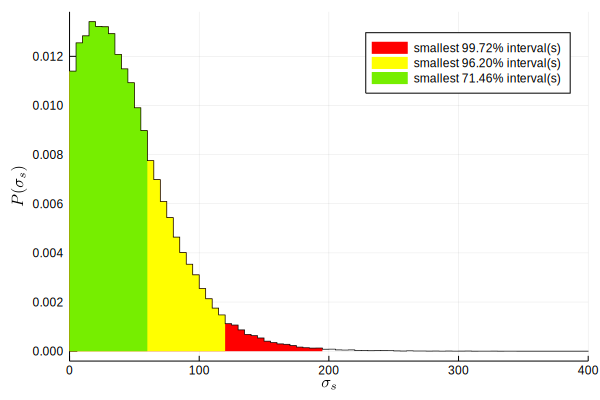

In [20]:
hist_σ = fit(Histogram, σS,nbins=200,closed = :left)
plot(hist_σ,1,seriestype=:smallest_intervals,xlim=(0,400),xlabel="\$\\sigma_s\$",ylabel="\$P(\\sigma_s)\$")

#!EX hist_σ = #!...!#
#!EX plot(#!...!#)

### Task 4b) Binomial analysis of calibration measurement with known source 
We now want to do the same analysis as in task 4 a) but for the case that the detector efficiency ε is not yet known.   

Instead, it is to be determined using a calibration measurement with a source for which the signal rate is known. Then we can calculate the efficiency from the expected number of counts and the counts actually measured with the detector.   


The number of expected events is $N_\text{expected} = 200$.
The detector measures $N_\text{measured} = 21$ events.  

Task: Implement a binomial model using the `Binomial(n,p)` function of the [Distrtibutions.jl](https://juliastats.github.io/Distributions.jl/latest/univariate/) package and determine distribution of the efficiency of the detector with BAT.
Afterwards, repeat the calculations in a) using the obtained distribution of the efficiency.

Define the binomial likelihood:

In [21]:
# Number of observed events
n_expected = 200
n_measured = 21

likelihood_binomial = let n = n_expected, k = n_measured
    params -> begin
        return logpdf(Binomial(n, params.p), k)
    end
end
#!EX likelihood_binomial = #!...!#

#15 (generic function with 1 method)

Define the prior (flat) for the efficiency and the posterior:

In [22]:
prior_binomial = NamedPrior(
    p = 0..1
)
#!EX prior_binomial = #!...!#

posterior_binomial = PosteriorDensity(likelihood_binomial, prior_binomial);
#!EX posterior_binomial = #!...!#

Generate the samples:

In [23]:
samples_binomial, sampleids_binomial, stats_binomial, chains_binomial = rand(MCMCSpec(algorithm, posterior_binomial), nsamples, nchains);
#!EX samples_binomial, sampleids_binomial, stats_binomial, chains_binomial = #!...!#

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 3 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 4 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/cornelius/.julia/packages/BAT/JqZhQ/src/samplers/mcmc/mcmc_tuner.jl:

Plot the efficiency:  
(what do you observe when comparing to the efficiency used in 4a ?)

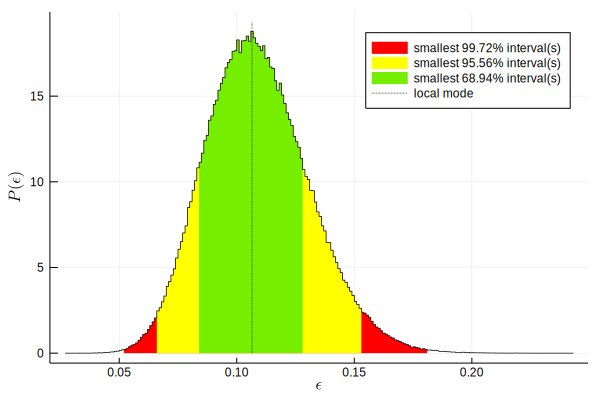

In [24]:
plot(samples_binomial, 1,xlabel="\$\\epsilon\$",ylabel="\$P(\\epsilon)\$")

In [25]:
println("Mode: $(stats_binomial.mode)")
println("Mean: $(stats_binomial.param_stats.mean)")
#println("Covariance: $(stats_binomial.param_stats.cov)")
println("Standard Deviation: $([sqrt((stats_binomial.param_stats.cov)[i,i]) for i in 1:(Int(sqrt(length(stats_binomial.param_stats.cov))))])")

Mode: [0.1050000021831868]
Mean: [0.10886640190959129]
Standard Deviation: [0.021874707865472832]


Calculate the cross section by sampling the same number of events from the efficiency and from the signal rate:

In [ ]:
λS  = sample(samples_SB.params.data[2,:],FrequencyWeights(samples_SB.weight),60000,replace=false,ordered=false)
ε   = sample(samples_binomial.params.data[1,:],FrequencyWeights(samples_binomial.weight),60000,replace=false,ordered=false)
σS  = λS./(ε*L)

#!EX λS  = sample(#!...!#)
#!EX ε   = sample(#!...!#)
#!EX σS  = #!...!#


Use a `StatsBase`histogram to visualize the cross section distribution.  
From the plot, determine the 95% upper limit on the cross section.

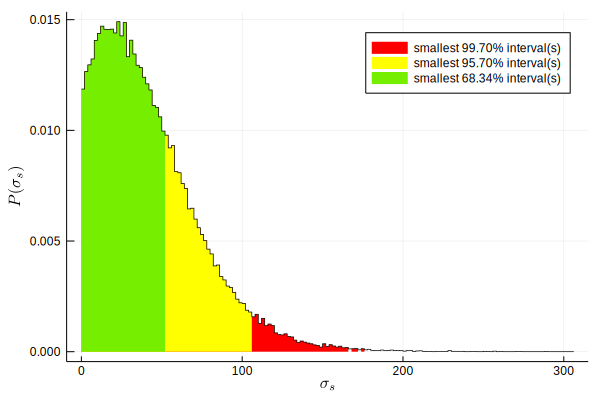

In [26]:
hist_σ = fit(Histogram, σS,nbins=200,closed = :left)
plot(hist_σ,1,seriestype=:smallest_intervals,xlabel="\$\\sigma_s\$",ylabel="\$P(\\sigma_s)\$")